In [0]:
#참고: https://programmers.co.kr/learn/courses/21/lessons/1701

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from bs4 import BeautifulSoup
import re
import time

from nltk.corpus import stopwords
import nltk.data

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from gensim.test.utils import datapath, get_tmpfile
feature_data = datapath('/content/gdrive/My Drive/AI/kaggle/' + '300features_40minwords_10text') 
train_data = datapath('/content/gdrive/My Drive/AI/kaggle/' + 'labeledTrainData.tsv') 
test_data = datapath('/content/gdrive/My Drive/AI/kaggle/' + 'testData.tsv') 

In [4]:
model = Word2Vec.load(feature_data)
#model.intersect_word2vec_format(fname=feature_file, binary=False)
model

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
# 숫자로 단어를 표현
# Word2Vec 모델은 어휘의 각 단어에 대한 feature 벡터로 구성되며
# 'syn0'이라는 넘파이 배열로 저장된다.
# syn0의 행 수는 모델 어휘의 단어 수
# 컬럼 수는 2부에서 설정한 피처 벡터의 크기
type(model.wv.syn0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [6]:
# syn0의 행 수는 모델 어휘의 단어 수
# 열 수는 2부에서 설정한 특징 벡터의 크기
model.wv.syn0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(11986, 300)

In [7]:
# 개별 단어 벡터 접근
model.wv['flower'].shape

(300,)

In [8]:
model.wv['flower'][:10]

array([ 0.01834406,  0.15109576,  0.08696021, -0.08180085,  0.18334594,
       -0.00667839,  0.09402244, -0.04177794,  0.04398022, -0.03917499],
      dtype=float32)

In [39]:
# 단어 벡터에서 k-means를 실행하고 일부 클러스터를 찍어본다.
start = time.time() # 시작시간

# 클러스터의 크기 "k"를 어휘 크기의 1/5이나 평균 5단어로 설정한다.
word_vectors = model.wv.syn0 # 어휘의 feature vector
print('word_vectors:', word_vectors)

num_clusters = word_vectors.shape[0] / 5
num_clusters = int(num_clusters)
print('word_vectors.shape[0]:', word_vectors.shape[0], ' ,num_clusters:', num_clusters)

# K means 를 정의하고 학습시킨다.
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# 끝난 시간에서 시작시각을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = end - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


word_vectors: [[ 0.0317538  -0.02474832  0.07860017 ... -0.09599912 -0.06242267
  -0.02094566]
 [-0.03075177 -0.00111953 -0.12395684 ... -0.02033539  0.06501389
   0.07448852]
 [ 0.03041891 -0.02029556  0.03499588 ... -0.04192805 -0.00141165
  -0.03356636]
 ...
 [ 0.02147275 -0.01034448 -0.03287955 ...  0.06800372  0.01527916
  -0.01323599]
 [ 0.17598395 -0.06208686 -0.08641047 ...  0.03861715  0.01693828
  -0.02470312]
 [ 0.0571405  -0.07898206 -0.03367015 ... -0.00755543 -0.01346191
  -0.10721017]]
word_vectors.shape[0]: 11986  ,num_clusters: 2397
Time taken for K Means clustering:  695.2943165302277 seconds.


In [63]:
# 각 어휘 단어를 클러스터 번호에 매핑되게 word/Index 사전을 만든다.
idx = list(idx)
names = model.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
#     word_centroid_map = dict(zip( model.wv.index2word, idx ))

sorted_names = sorted(word_centroid_map.items(), key=lambda x: x[1], reverse=True) #value로 소팅(여기서 value는 idx)
cnt=0
for i, name in enumerate(sorted_names):
    print(':', i, ' ,name:',name)
    if(cnt>=50): break
    cnt=cnt+1
    

# 첫 번째 클러스터의 처음 10개를 출력
for cluster in range(0,10):
    # 클러스터 번호를 출력
    print("\nCluster {}".format(cluster))

    # 클러스터 번호와 클러스터에 있는 단어를 찍는다.
    words = []
    for i in range(0,len(list(word_centroid_map.values()))):
        if( list(word_centroid_map.values())[i] == cluster ):
            words.append(list(word_centroid_map.keys())[i])
    print(words)

: 0  ,name: ('salut', 2396)
: 1  ,name: ('throwaway', 2395)
: 2  ,name: ('hoax', 2394)
: 3  ,name: ('outta', 2393)
: 4  ,name: ('bash', 2392)
: 5  ,name: ('rough', 2391)
: 6  ,name: ('sting', 2390)
: 7  ,name: ('howler', 2390)
: 8  ,name: ('smother', 2390)
: 9  ,name: ('blah', 2389)
: 10  ,name: ('yada', 2389)
: 11  ,name: ('dun', 2389)
: 12  ,name: ('old', 2388)
: 13  ,name: ('ago', 2388)
: 14  ,name: ('field', 2387)
: 15  ,name: ('fish', 2387)
: 16  ,name: ('belt', 2387)
: 17  ,name: ('jam', 2387)
: 18  ,name: ('branch', 2387)
: 19  ,name: ('deck', 2387)
: 20  ,name: ('leaf', 2387)
: 21  ,name: ('rubbl', 2387)
: 22  ,name: ('pioneer', 2386)
: 23  ,name: ('rever', 2386)
: 24  ,name: ('quintessenti', 2386)
: 25  ,name: ('renown', 2386)
: 26  ,name: ('panahi', 2386)
: 27  ,name: ('curb', 2385)
: 28  ,name: ('pc', 2384)
: 29  ,name: ('er', 2383)
: 30  ,name: ('ne', 2383)
: 31  ,name: ('birch', 2382)
: 32  ,name: ('thora', 2382)
: 33  ,name: ('witherspoon', 2382)
: 34  ,name: ('outshin', 

In [37]:
"""
판다스로 데이터프레임 형태의 데이터로 읽어온다.
QUOTE_MINIMAL (0), QUOTE_ALL (1), 
QUOTE_NONNUMERIC (2) or QUOTE_NONE (3).

그리고 이전 튜토리얼에서 했던 것처럼 clean_train_reviews 와 
clean_test_reviews 로 텍스트를 정제한다.
"""
train = pd.read_csv(train_data, header=0, delimiter="\t", quoting=3)
test = pd.read_csv(test_data, header=0, delimiter="\t", quoting=3)
# unlabeled_train = pd.read_csv( 'data/unlabeledTrainData.tsv', header=0,  delimiter="\t", quoting=3 )

print(train)
print(train['sentiment'][0], ':', train['review'][0])
print(train['sentiment'][2], ':', train['review'][2])

              id  sentiment                                             review
0       "5814_8"          1  "With all this stuff going down at the moment ...
1       "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2       "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3       "3630_4"          0  "It must be assumed that those who praised thi...
4       "9495_8"          1  "Superbly trashy and wondrously unpretentious ...
...          ...        ...                                                ...
24995   "3453_3"          0  "It seems like more consideration has gone int...
24996   "5064_1"          0  "I don't believe they made this film. Complete...
24997  "10905_3"          0  "Guy is a loser. Can't get girls, needs to bui...
24998  "10194_3"          0  "This 30 minute documentary Buñuel made in the...
24999   "8478_8"          1  "I saw this movie as a child and it broke my h...

[25000 rows x 3 columns]
1 : "With all this stuff g

In [12]:
#https://github.com/wendykan/DeepLearningMovies/blob/master/KaggleWord2VecUtility.py
import re
import nltk
nltk.download('stopwords')

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords

class KaggleWord2VecUtility(object):
    """KaggleWord2VecUtility is a utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review).get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.decode('utf8').strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append( KaggleWord2VecUtility.review_to_wordlist( raw_sentence, \
                  remove_stopwords ))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# 학습 리뷰를 정제한다.
clean_train_reviews = []
for review in train["review"]:
    clean_train_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [0]:
# 테스트 리뷰를 정제한다.
clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append(
        KaggleWord2VecUtility.review_to_wordlist( review, \
        remove_stopwords=True ))

In [15]:
# bags of centroids 생성
# 속도를 위해 centroid 학습 세트 bag을 미리 할당한다.
train_centroids = np.zeros((train["review"].size, num_clusters), \
    dtype="float32" )

train_centroids[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
# centroid 는 두 클러스터의 중심점을 정의 한 다음 중심점의 거리를 측정한 것
def create_bag_of_centroids( wordlist, word_centroid_map ):

    # 클러스터의 수는 word / centroid map에서 가장 높은 클러스트 인덱스와 같다.
    num_centroids = max( word_centroid_map.values() ) + 1
    print("num_centroids:", num_centroids)

    # 속도를 위해 bag of centroids vector를 미리 할당한다.
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    print("bag_of_centroids:", bag_of_centroids)

    # 루프를 돌며 단어가 word_centroid_map에 있다면
    # 해당하는 클러스터의 수를 하나씩 증가시켜 준다.
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
            print('word_centroid_map!!! word:', word, ',map index:',index, ',bag_of_centroids[index]:', bag_of_centroids[index])

    print('bag_of_centroids:', bag_of_centroids)
    # bag of centroids를 반환한다.
    return bag_of_centroids

In [25]:
# 학습 리뷰를 bags of centroids로 변환한다.
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    if counter >= 0 : break
    counter += 1

print(train_centroids[0])

# 테스트 리뷰도 같은 방법으로 반복해 준다.
test_centroids = np.zeros(( test["review"].size, num_clusters), \
    dtype="float32" )

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids( review, \
        word_centroid_map )
    if counter >= 0 : break
    counter += 1


# 랜덤포레스트를 사용하여 학습시키고 예측
forest = RandomForestClassifier(n_estimators = 100)

# train 데이터의 레이블을 통해 학습시키고 예측한다.
# 시간이 좀 소요되기 때문에 %time을 통해 걸린 시간을 찍도록 함
print("Fitting a random forest to labeled training data...")
%time forest = forest.fit(train_centroids, train["sentiment"])

num_centroids: 2397
bag_of_centroids: [0. 0. 0. ... 0. 0. 0.]
word_centroid_map!!! word: stuff ,map index: 2350 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: moment ,map index: 1262 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: mj ,map index: 1141 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: music ,map index: 908 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: odd ,map index: 1441 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: want ,map index: 1502 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: get ,map index: 724 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: certain ,map index: 462 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: insight ,map index: 1073 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: guy ,map index: 1107 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: thought ,map index: 1448 ,bag_of_centroids[index]: 1.0
word_centroid_map!!! word: cool ,map index: 411 ,bag_of_centroid

In [18]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, train_centroids, train['sentiment'], cv=10,\
    scoring='roc_auc'))

CPU times: user 3min 56s, sys: 262 ms, total: 3min 56s
Wall time: 3min 56s


In [19]:
%time result = forest.predict(test_centroids)

CPU times: user 1.68 s, sys: 2.51 ms, total: 1.68 s
Wall time: 1.69 s


In [20]:
score

0.869580128

In [0]:
# 결과를 csv로 저장
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("submit_BagOfCentroids_{0:.5f}.csv".format(score), index=False, quoting=3)

In [31]:
ls -alrt

total 300
drwxr-xr-x 1 root root   4096 Feb  5 18:37 sample_data/
drwxr-xr-x 1 root root   4096 Feb  6 17:12 .config/
drwxr-xr-x 1 root root   4096 Feb  8 07:14 ../
drwx------ 4 root root   4096 Feb  8 07:16 gdrive/
drwxr-xr-x 1 root root   4096 Feb  8 08:08 ./
-rw-r--r-- 1 root root 282792 Feb  8 08:08 submit_BagOfCentroids_0.86958.csv


In [0]:
from google.colab import files
files.download("/content/submit_BagOfCentroids_0.86958.csv")

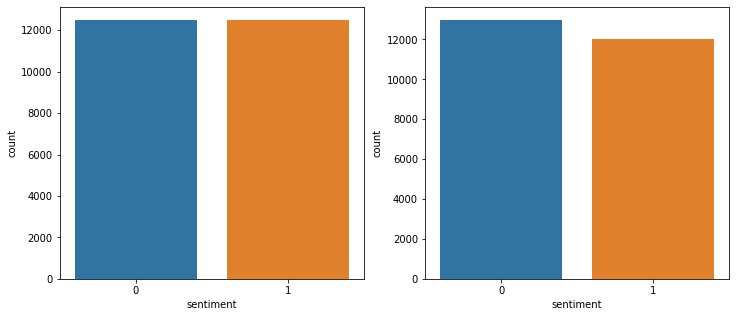

In [33]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

In [34]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

954


0    12977
1    12023
Name: sentiment, dtype: int64